In [1]:
import sys
sys.path.insert(1,'../')

from jax import vmap
import jax.numpy as jnp
import jax.random as jxr

import models
import inference
import visualizations
import simulations
import utils
import params

%load_ext autoreload
%autoreload 2

In [8]:
# %% Global params

save = False
file = '../results/networks/'

T = 10 # Total time (wrt the dt)
dt = .05 # Time discretization
K = 10 # Number of trials
N = 2 # Number of observation dimensions
seed = 9 # Data's random seed


In [9]:
# Interventional input
key = jxr.PRNGKey(seed)
k1, key = jxr.split(key,2)

u = []

# By changing the amplitude from 1 to 0 we move from 
# interventional regime to observational regime

for i in range(K):
    u_,_ = utils.stimulation_protocol(
        k1, time_st=0, time_en=T, dt=dt, N=N,
        stimulated=jnp.arange(N), amplitude=1*jnp.ones(N),
        stim_d=1., rest_d=1., repetition=15, sigma=.5
    )
    u.append(u_)

u = jnp.array(u)

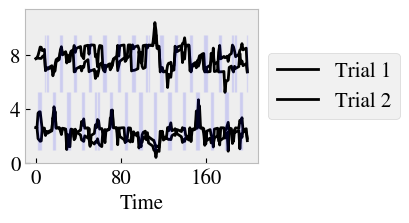

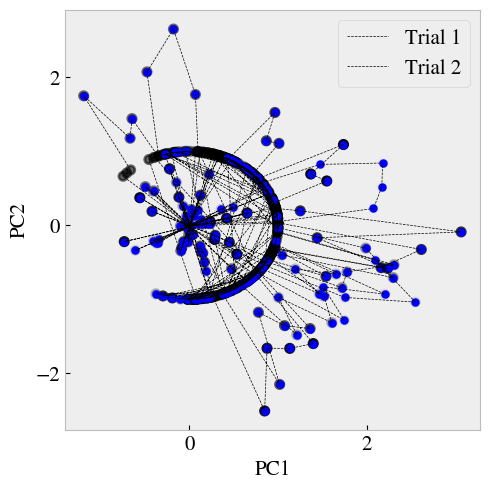

In [10]:
# Simulate data from a motor cortex dynamical model

k1, key = jxr.split(key,2)

# The following simulation can be replaced with this other model
# These models are adopted from https://www.nature.com/articles/s41593-022-01230-2
# p = {'a':1.2,'sigma':0,'D':2}
# system = networks.RotationalDynamics(p,discrete=True)

p = {'a1':-20, 'a2': 1.2, 'sigma':0.,'D':2}
system = simulations.DynamicAttractor(p,discrete=True)

t,x_ = system.run(
    T,dt=dt,u=u,
    x0=.01*jxr.normal(k1,shape=(K,p['D']))
)
y_ = system.obs(x_)
y = jnp.array([y_[:,i] for i in range(y_.shape[1])])
    

visualizations.plot_signals(y[:2],inp=u[0],labels=['Trial 1', 'Trial 2'])
visualizations.plot_states(y[:2],input=u[0],labels=['Trial 1', 'Trial 2'])

In [11]:
seed = 1 # Model's random seed

key = jxr.PRNGKey(seed)
k1,k2,k3,key = jxr.split(key,4)

# Initial parameters for InitialCondition
initial_params = params.ParamsNormal(
    mu = jnp.zeros(N),
    scale_tril = dt*jnp.eye(N)
)

# Initial parameters for the linear dynamical system
lds_params = params.ParamsLinearDynamics(
    scale_tril = dt*jnp.eye(N),
    A = jxr.normal(k1, shape=(N,N)),
    B = jnp.eye(N),
    initial = initial_params
)

# Initial likelihood parameter
likelihood_params = params.ParamsConditionalNormal(
    scale_tril = dt*jnp.eye(N)
)

# Create instances of model blocks (Dynamics, Emission, Likelihood, Joint, Recognition)
initial = models.InitialCondition(N, initial_params)

# The control matrix B can be made trianable by setting `train_B` to `True` 
lds = models.LinearDynamics(D=N,M=N,initial=initial,params=lds_params,dt=dt,train_B=False,interventional=True)
emission = models.NeuralNetEmission(N,N,key=k2,H=100)
likelihood = models.NormalConditionalLikelihood(N,params=likelihood_params)
joint = models.fLDS(lds,emission,likelihood)
recognition = inference.AmortizedLSTM(D=N,N=N,M=N,key=k3,T=y.shape[1],interventional=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

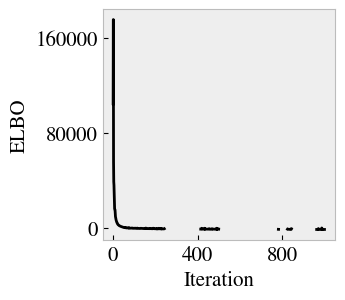

In [12]:
# Fit the joint model and recognition model parameters

k1, key = jxr.split(key,2)


loss = inference.infer(
    k1,joint,recognition,y,u,
    n_iter=1000,step_size=1e-2,
    gamma=0
)

visualizations.plot_loss(loss,ylabel='ELBO',save=save,file=file+'loss')

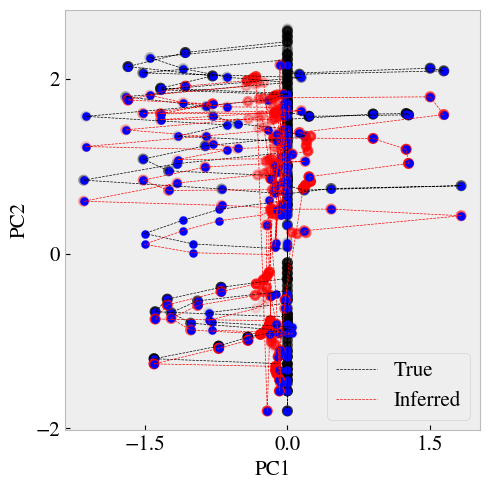

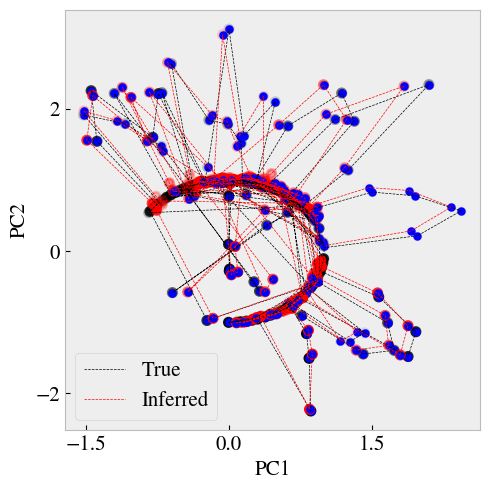

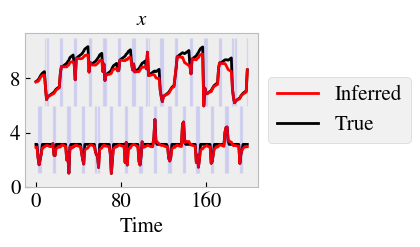

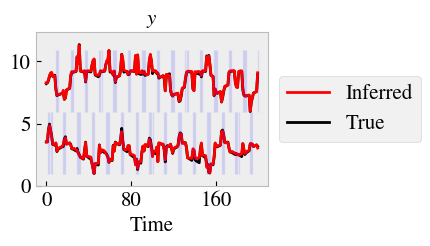

In [13]:
# Infer the latents and denoise the data using trained models

k1, k2, key = jxr.split(key,3)

x_smooth = vmap(
    lambda y,u: recognition(recognition.params,k1,y,u)[0],
    in_axes=(0,0),out_axes=0
)(y,u)

mean = vmap(
    lambda x: emission(emission.params,x),
    in_axes=(0),out_axes=0
)(x_smooth)

y_smooth = vmap(
    lambda mu: likelihood.sample(likelihood_params,mu,key=k2),
    in_axes=(0),out_axes=0
)(mean)

    
visualizations.plot_states([x_[:,i],x_smooth[i]], input=u[i],colors=['k','r'], labels=['True','Inferred'])
visualizations.plot_states([y[i],mean[i]], input=u[i],colors=['k','r'], labels=['True','Inferred'])

visualizations.plot_signals(
    [x_[:,i],x_smooth[i]],inp=u[i],colors=['k','r'],
    titlestr='$x$',labels=['True','Inferred']
)
visualizations.plot_signals(
    [y[i],mean[i]],inp=u[i],colors=['k','r'],
    titlestr='$y$',labels=['True','Inferred']
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


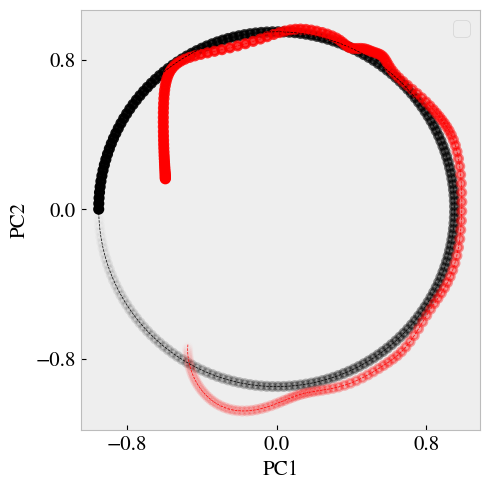

In [14]:
# Create a grid in the latent space and see how the emission model maps it to the observation space

lin_x = jnp.stack((.05+jnp.zeros(y.shape[1]),jnp.linspace(-jnp.pi,jnp.pi,y.shape[1]))).T
true_lin_y = system.obs(lin_x)
lin_y = emission(emission.params,lin_x)

visualizations.plot_states([true_lin_y,lin_y],input=0*u[i],colors=['k','r'])

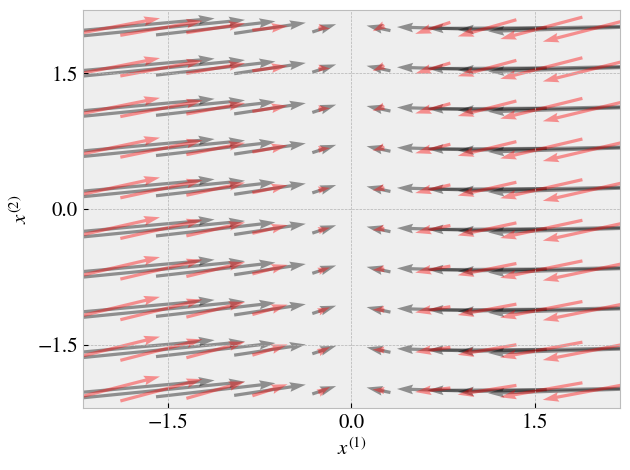

In [15]:
# Compare true and inferred latent flow fields

true_flow_x = lambda x: system.step(0,x)
inferred_flow_x = lambda x: (lds.params.A@x.T).T-x

visualizations.flow_2d(
    [true_flow_x, inferred_flow_x],
    colors=[[0,0,0,.4], [1,0,0,.4]],
    # colors=['k', 'r'],
    scale=1e-2,
    xlim=[-2,2],
    ylim=[-2,2],
    n_points=10,
    save=save,file=file+'inferred_flow'
)
